In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random
random.seed(42)
plt.style.use('dark_background')

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

Randomly sampling a subset of the data, to make the combinations more tractable. 

(28, 28)


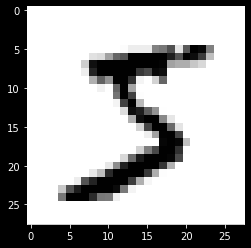

In [4]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

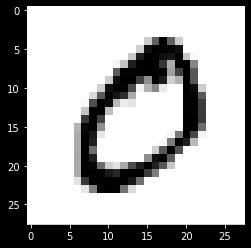

In [5]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

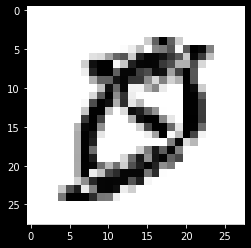

In [6]:
images_A_and_B = image_A + image_B
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [7]:
# Create mini training set so that it's not too computationally intensive
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [8]:
# Randomly draw 40k training images

num_images_chosen = 300000
num_images_total = 40000

combo_train_X = []
combo_train_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_train[rand_A]
    image_B = X_train[rand_B]
    concatenated_images = image_A + image_B
    
    # Find the minimum label
    intermediate_label_A = y_train[rand_A]
    intermediate_label_B = y_train[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_train_X.append(concatenated_images)
    combo_train_y.append(minimum_label)
    
combo_train_X = np.array(combo_train_X)
combo_train_y = np.array(combo_train_y)

In [9]:
# Randomly draw 20k validation images

num_images_chosen = 10000
num_images_total = 20000

combo_val_X = []
combo_val_y = []

for i in range(num_images_chosen):
    
    # Randomly draw indices
    rand_A = random.randint(0, num_images_total-1)
    rand_B = random.randint(0, num_images_total-1)
    
    # Concatenate images
    image_A = X_val[rand_A]
    image_B = X_val[rand_B]
    concatenated_images = image_A + image_B
    
    # Find the minimum label
    intermediate_label_A = y_val[rand_A]
    intermediate_label_B = y_val[rand_B]
    minimum_label = min(intermediate_label_A, intermediate_label_B)
    
    # Append to lists
    combo_val_X.append(concatenated_images)
    combo_val_y.append(minimum_label)
    
combo_val_X = np.array(combo_val_X)
combo_val_y = np.array(combo_val_y)

In [10]:
combo_val_X.shape

(10000, 28, 28)

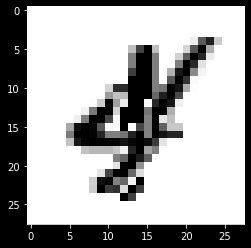

In [12]:
plt.imshow(combo_val_X[1000], cmap = plt.cm.binary)

In [15]:
train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 28, 1))
train_images = train_images.astype('float32')/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 28, 1))
val_images = val_images.astype('float32')/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [16]:
train_images.shape

(300000, 28, 28, 1)

In [17]:
val_images.shape

(10000, 28, 28, 1)

In [18]:
train_labels.shape

(300000, 10)

In [19]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# Adding a classifier
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dropout (Dropout)            (None, 576)               0

In [21]:

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0002)

model.compile(optimizer = opt,
             loss = 'categorical_crossentropy',
             metrics = ['mae'])

# model.compile(optimizer = 'rmsprop',
#              loss = 'categorical_crossentropy',
#              metrics = ['accuracy', 'mae'])


In [ ]:
# Run model in one go
model.reset_states()
history = model.fit(train_images, 
          train_labels, 
          epochs = 30, 
          batch_size = 64,
          validation_data = (val_images, val_labels))

val_mae_history = history.history['val_mae']
print(val_mae_history)

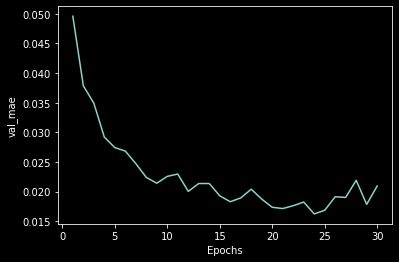

In [22]:
plt.plot(range(1, len(val_mae_history) + 1), val_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [23]:
y_predict = model.predict(val_images)
#y_predict = y_predict.astype(int)


correct = 0
#check_baseline

for label in range(len(val_labels)):
    
    if np.argmax(val_labels[label], axis=None, out=None) == np.argmax(y_predict[label], axis=None, out=None):
        correct = correct + 1
        
print("Val Accuracy: " + str(correct/len(val_labels)))

Val Accuracy: 0.9302


Baseline for above is 10%

In [24]:
eval_model = model.evaluate(val_images, val_labels)
eval_model

313/313 [==============================] - 1s 2ms/step - loss: 0.2189 - mae: 0.0209


[0.2189028263092041, 0.02094152942299843]